# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# Load data

In [2]:
"""
Data obtained from: https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set
"""

data_dir = 'data'

with open(os.path.join(data_dir, 'divorce.csv')) as clean_data_file:
    data = pd.read_csv(clean_data_file, delimiter=';')
    
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()

divorced = y.astype(bool)
married = ~divorced

print('Number of data points:', X.shape[0])
print('Number of features/statements:', X.shape[1])

Number of data points: 170
Number of features/statements: 54


In [3]:
statements = {'1': "If one of us apologizes when our discussion deteriorates, the discussion ends.",
'2': "I know we can ignore our differences, even if things get hard sometimes.",
'3': "When we need it, we can take our discussions with my spouse from the beginning and correct it.",
'4': "When I discuss with my spouse, to contact him will eventually work.",
'5': "The time I spent with my wife is special for us.",
'6': "We don't have time at home as partners.",
'7': "We are like two strangers who share the same environment at home rather than family.",
'8': "I enjoy our holidays with my wife.",
'9': "I enjoy traveling with my wife.",
'10': "Most of our goals are common to my spouse.",
'11': "I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other.",
'12': "My spouse and I have similar values in terms of personal freedom.",
'13': "My spouse and I have similar sense of entertainment.",
'14': "Most of our goals for people (children, friends, etc.) are the same.",
'15': "Our dreams with my spouse are similar and harmonious.",
'16': "We're compatible with my spouse about what love should be.",
'17': "We share the same views about being happy in our life with my spouse",
'18': "My spouse and I have similar ideas about how marriage should be",
'19': "My spouse and I have similar ideas about how roles should be in marriage",
'20': "My spouse and I have similar values in trust.",
'21': "I know exactly what my wife likes.",
'22': "I know how my spouse wants to be taken care of when she/he sick.",
'23': "I know my spouse's favorite food.",
'24': "I can tell you what kind of stress my spouse is facing in her/his life.",
'25': "I have knowledge of my spouse's inner world.",
'26': "I know my spouse's basic anxieties.",
'27': "I know what my spouse's current sources of stress are.",
'28': "I know my spouse's hopes and wishes.",
'29': "I know my spouse very well.",
'30': "I know my spouse's friends and their social relationships.",
'31': "I feel aggressive when I argue with my spouse.",
'32': "When discussing with my spouse, I usually use expressions such as ‘you always’ or ‘you never’ .",
'33': "I can use negative statements about my spouse's personality during our discussions.",
'34': "I can use offensive expressions during our discussions.",
'35': "I can insult my spouse during our discussions.",
'36': "I can be humiliating when we discussions.",
'37': "My discussion with my spouse is not calm.",
'38': "I hate my spouse's way of open a subject.",
'39': "Our discussions often occur suddenly.",
'40': "We're just starting a discussion before I know what's going on.",
'41': "When I talk to my spouse about something, my calm suddenly breaks.",
'42': "When I argue with my spouse, ı only go out and I don't say a word.",
'43': "I mostly stay silent to calm the environment a little bit.",
'44': "Sometimes I think it's good for me to leave home for a while.",
'45': "I'd rather stay silent than discuss with my spouse.",
'46': "Even if I'm right in the discussion, I stay silent to hurt my spouse.",
'47': "When I discuss with my spouse, I stay silent because I am afraid of not being able to control my anger.",
'48': "I feel right in our discussions.",
'49': "I have nothing to do with what I've been accused of.",
'50': "I'm not actually the one who's guilty about what I'm accused of.",
'51': "I'm not the one who's wrong about problems at home.",
'52': "I wouldn't hesitate to tell my spouse about her/his inadequacy.",
'53': "When I discuss, I remind my spouse of her/his inadequacy.",
'54': "I'm not afraid to tell my spouse about her/his incompetence."}

# Explore data

In [4]:
"""
Features meaning: 0 = 'strongly agree', 4 = 'strongly disagree'
Labels meaning: 0 = 'married', 1 = 'divorced'

The words 'wife' and 'spouse' should be considered interchangeable in the statements.
The statements are presumably translated from Turkish 
and the meaning of the statements in English is unfortunately not always 100% clear.

Original paper link:
https://dergipark.org.tr/en/pub/nevsosbilen/issue/46568/549416

Data was collected through face-to-face interviews and Google drive questionaires. 
Divorced participants were asked to reflect back(!) on their marriage.
Married participants only included happy marriages, i.e. those that did not have any thoughts about divorce.

Reported characteristics of participants:
- divorced: 84 (49%), married 86 (51%) 
- male 84 (49%), female 86 (51%) 
- age: min 20, max 63, mean 36.04, std 9.34
- 7 different regions in Turkey, predominantly from the Black Sea region 79 (46.4%)
- married for love 74 (43.5%), arranged marriage 96 (56.5%) 
- with children 127 (74.7%), without children 43 (25.3%)
- primary school graduate 18 (10.58%), secondary school graduate 15 (8.8%), high school graduate 33 (19.41%),
college graduate 88 (51.76%), master degree 15 (8.8%)
- income: <2000 TL 34 (20%), 2001-3000 TL 54 (31.76%), 3001-4000 TL 28 (16.47%), >4000 TL 54 (31.76%)

Another analysis of the data: (statements 9, 11, 18, 19, 26, and 40 are determined to be the best predictors)
https://ongjk.github.io/supervise.html

Kaggle also has the dataset: (note the statements are sometimes formulated differently in the description)
https://www.kaggle.com/adisak/divorce-predictors-data-set
"""

n_examples = 10
atrs = [9, 11, 18, 19, 26, 40]

for atr in atrs:
    print('Statement:', statements[str(atr)])
    print('Divorced subset answers:', data[:n_examples][f'Atr{atr}'].values)
    print('Married subset answers:', data[-n_examples:][f'Atr{atr}'].values)
    print(' ')

Statement: I enjoy traveling with my wife.
Divorced subset answers: [0 4 1 3 0 0 2 3 3 2]
Married subset answers: [0 1 0 0 0 0 0 0 0 0]
 
Statement: I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other.
Divorced subset answers: [1 4 3 4 0 0 2 4 3 3]
Married subset answers: [0 1 0 1 0 0 0 0 0 0]
 
Statement: My spouse and I have similar ideas about how marriage should be
Divorced subset answers: [0 4 3 3 1 1 3 3 3 2]
Married subset answers: [0 1 0 0 0 0 0 0 0 0]
 
Statement: My spouse and I have similar ideas about how roles should be in marriage
Divorced subset answers: [0 3 3 3 2 0 3 2 3 1]
Married subset answers: [0 0 0 0 0 0 0 0 0 0]
 
Statement: I know my spouse's basic anxieties.
Divorced subset answers: [0 1 2 1 2 2 3 3 3 1]
Married subset answers: [0 0 0 1 1 0 0 1 0 0]
 
Statement: We're just starting a discussion before I know what's going on.
Divorced subset answers: [3 4 3 4 1 2 3 4 2 2]
Married subset answers: 

# Functions

In [5]:
def plot_components(comp_divorced, comp_married, comp1, comp2, method):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(comp_divorced.T[comp1 - 1], comp_divorced.T[comp2 - 1], label='divorced')
    ax.scatter(comp_married.T[comp1 - 1], comp_married.T[comp2 - 1], label='married')
    ax.set_title(f'{method} components {comp1} and {comp2}')
    ax.set_xlabel(f'component {comp1}')
    ax.set_ylabel(f'component {comp2}')
    ax.legend()
    plt.show()

# PCA

Component 1 accounts for 77.22180991968564% of the variance.
Component 2 accounts for 3.5265046871057826% of the variance.


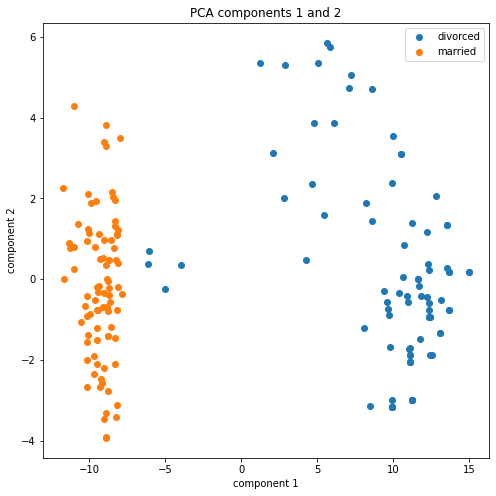

In [6]:
# Reduce the data to a number of components
n_comp = 2
pca = PCA(n_components=n_comp)
fit = pca.fit(X)
comp = fit.transform(X)

# Divide into divorced and married subset
comp_divorced = comp[divorced]
comp_married = comp[married]

# Select components
comp1 = 1
comp2 = 2

# Print the variance explained by the components
var = pca.explained_variance_ratio_
print(f'Component {comp1} accounts for {var[comp1 - 1] * 100}% of the variance.')
print(f'Component {comp2} accounts for {var[comp2 - 1] * 100}% of the variance.')

# Plot components
plot_components(comp_divorced, comp_married, comp1, comp2, method='PCA')

# LLE

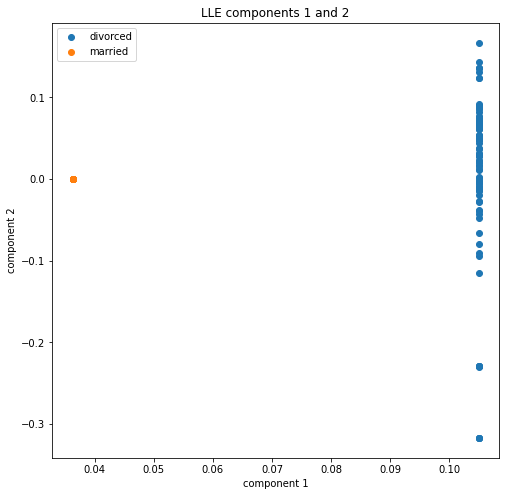

In [7]:
# Reduce the data to a number of components
n_comp = 2
lle = LocallyLinearEmbedding(n_components=n_comp)
comp = lle.fit_transform(X, y=y)

# Divide into divorced and married subset
comp_divorced = comp[divorced]
comp_married = comp[married]

# Select components
comp1 = 1
comp2 = 2

# Plot components
plot_components(comp_divorced, comp_married, comp1, comp2, method='LLE')

# t-SNE

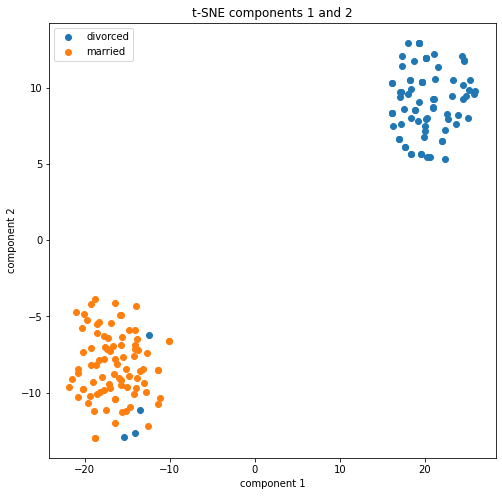

In [8]:
# Reduce the data to a number of components
n_comp = 2
tsne = TSNE(n_components=n_comp, random_state=42)
comp = tsne.fit_transform(X, y=y)

# Divide into divorced and married subset
comp_divorced = comp[divorced]
comp_married = comp[married]

# Select components
comp1 = 1
comp2 = 2

# Plot components
plot_components(comp_divorced, comp_married, comp1, comp2, method='t-SNE')